In [288]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import time
from dwave_sapi2.remote import RemoteConnection
from dwave_sapi2.core import solve_ising
from dwave_sapi2.util import qubo_to_ising, get_hardware_adjacency
from dwave_sapi2.embedding import find_embedding, embed_problem, unembed_answer

url = 'https://cloud.dwavesys.com/sapi/'

In [289]:
with open('config.txt', 'r') as f:
    token = f.read()

In [290]:
N = 6 # スピン数

In [291]:
# スピンをランダムに初期化({-1,1}で)
def init_spin():
    return np.random.randint(0,2,N)*2 - 1

In [292]:
# イジング模型の相互作用J（上三角行列（対角成分は含まない））
def coeff_J():
    J = np.zeros((N,N))
    for i in range(N):
        for j in range(i+1,N):
            J[i][j] = 1
    return J
coeffJ = coeff_J()

In [293]:
# イジング模型の変数同士のリンク情報の獲得
def link_J():
    link = [[] for _ in range(N)]
    for i in range(N):
        for j in range(i+1, N):
            if coeffJ[i][j] != 0:
                link[i].append(j)
                link[j].append(i)
    return link
link = link_J()

In [294]:
# イジング模型の係数h
def coeff_h():
    h = np.zeros(N)
    return h
coeffh = coeff_h()

In [295]:
# エネルギー関数
def energy(spin):
    return -(np.dot(spin, np.dot(coeffJ, spin)) + np.dot(coeffh, spin))

In [296]:
# 取りうる状態の数え上げ（組み合わせ爆発に注意）
comb_all = list(itertools.product([-1,1], repeat=N))
comb_all_to_index = {}
for i, c in enumerate(comb_all):
    comb_all_to_index[tuple(c)] = i

In [297]:
# ○表示系
# 真の確率分布の表示（組み合わせ爆発に注意）
# 取りうる状態を[0,0,...,0]から[1,1,..,1]まで辞書順に並べた際のインデックスを横軸（これ意味ある？）
def disp_GT_per_index(T = 1):
    ground_truth_prob = np.zeros(2**N).astype(np.float32)
    ground_truth_energy = np.zeros(2**N).astype(np.float32)
    for i, c in enumerate(comb_all):
        ground_truth_energy[i] = energy(np.array(c))
        ground_truth_prob[i] = np.exp(-ground_truth_energy[i] / T)
    ground_truth_prob = ground_truth_prob / np.sum(ground_truth_prob)
    plt.figure(figsize=(8,6))
    plt.title('ground truth')
    plt.xlabel('index')
    plt.ylabel('probability')
    plt.bar(np.arange(2**N), ground_truth_prob)
    plt.show()

In [298]:
# ○表示系
# サンプリング結果から導き出した確率分布の表示（組み合わせ爆発に注意）
# 取りうる状態を[0,0,...,0]から[1,1,..,1]まで順に並べた際のインデックスを横軸（これ意味ある？）
def disp_result_per_index(answer, num, method):
    prob = np.zeros(2**N).astype(np.float32)
    for a, n in zip(answer, num):
        prob[comb_all_to_index[tuple(a)]] += n
    prob = prob / np.sum(prob)
    plt.figure(figsize=(8,6))
    plt.title('sampling result' + ' by ' + method)
    plt.xlabel('index')
    plt.ylabel('probability')
    plt.bar(np.arange(2**N), prob)
    plt.show()

In [299]:
# ○表示系
# 真の確率分布との間のKLダイバージェンスを計算（組合せ爆発に注意）
# インデックスを対応させつつanswerにサンプル結果の変数の列、numにその解の登場回数を入れること（MCMCの結果の場合はnp.ones(len(data))）
def KL_divergence(answer, num, T = 1):
    ground_truth_prob = np.zeros(2**N).astype(np.float32)
    sampled_prob = np.zeros(2**N).astype(np.float32)
    for i, c in enumerate(comb_all):
        ground_truth_prob[i] = np.exp(-energy(np.array(c)) / T)
    for a, n in zip(answer, num):
        sampled_prob[comb_all_to_index[tuple(a)]] += n
    ground_truth_prob = ground_truth_prob / np.sum(ground_truth_prob)
    sampled_prob = sampled_prob / np.sum(sampled_prob)
    KL_div = 0
    for i in range(2**N):
        if sampled_prob[i] != 0:
            KL_div += sampled_prob[i] * np.log(sampled_prob[i] / ground_truth_prob[i])
    return KL_div

In [300]:
# MCMC
# メトロポリス法で１スピンずつ更新する
def onespinflip_metropolis(spin, i, T = 1):
    b_E = energy(spin)
    spin[i] = -spin[i]
    a_E = energy(spin)
    update_prob = min(1, np.exp((b_E - a_E) / T)) # 更新前後の状態の確率の比を取る(カノニカル分布でマイナスがかかるので符号反転)
    p = np.random.uniform(0,1)
    if p < update_prob:
        pass
    else:
        spin[i] = -spin[i]
    return spin

In [301]:
# MCMC
# 熱浴法で１スピンずつ更新する
def onespinflip_gibbs(spin, i, T = 1):
    link_energy = coeffh[i]
    for l in link[i]:
        link_energy += coeffJ[min(i,l)][max(i,l)] * spin[l]
    update_prob = (1 + np.tanh(link_energy)) / 2
    p = np.random.uniform(0,1)
    if p < update_prob:
        spin[i] = 1
    else:
        spin[i] = -1
    return spin

In [302]:
# MCMC
# サンプリングを実行 サンプラーと取得するサンプル数、サンプル間隔、初期緩和時間を指定
def sampling_MCMC(sampler, N_sampling, interval, relax = 0, T = 1):
    start = time.time()
    spin = init_spin()
    samples = [0 for _ in range(N_sampling)]
    
    for i in range(relax):
        for j in range(N):
            spin = sampler(spin, j, T)
            
    for i in range(N_sampling):
        for j in range(interval):
            for k in range(N):
                spin = sampler(spin, k, T)
        samples[i] = np.array(spin)
    print 'elasped_time: ', time.time() - start, '[s]'
    return samples

In [303]:
# D-waveへ送信するための準備
J = {}
S = {}
for i in range(N):
    for j in range(i+1, N):
        if coeffJ[i][j] != 0:
            J[(i, j)] = -coeffJ[i][j].astype(np.float64)
            S[(i, j)] = 1
h = list(-coeffh.astype(np.float32))

In [304]:
# 問題をキメラグラフに埋め込み
# D-waveに接続
connection = RemoteConnection(url, token)
print connection.solver_names()
solver_name = 'DW_2000Q_2'
solver = connection.get_solver(solver_name)

A = get_hardware_adjacency(solver)
embeddings = find_embedding(S, A, verbose = 1) 

['DW_2000Q_VFYC_2', 'DW_2000Q_2', 'c4-sw_optimize', 'c4-sw_sample']
component 0, try 0:
max overfill = 1, num max overfills = 17
max overfill = 1, num max overfills = 17
Embedding found. Minimizing chains...
max chain size = 5, num max chains = 1, qubits used = 17
max chain size = 4, num max chains = 1, qubits used = 15
max chain size = 3, num max chains = 2, qubits used = 14
max chain size = 3, num max chains = 2, qubits used = 14


In [305]:
# 実際に問題を送信する num_readsでサンプル数（実行回数）を指定
(h0, j0, jc, new_emb) = embed_problem(h, J, embeddings, A)
emb_j = j0.copy()
emb_j.update(jc)
answer = solve_ising(solver, h0, emb_j, num_reads = 5000)

In [306]:
# 答えをデコード
decode_answer = unembed_answer(answer['solutions'], new_emb, 'minimize_energy', h, J)
num_answer = answer['num_occurrences']

In [307]:
data = sampling_MCMC(sampler = onespinflip_gibbs, N_sampling = 5000, interval = 200, relax = 1000)

elasped_time:  52.2829999924 [s]


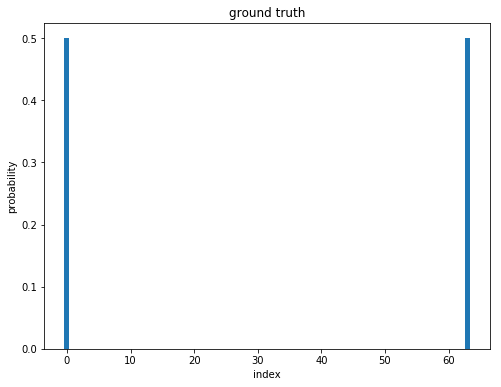

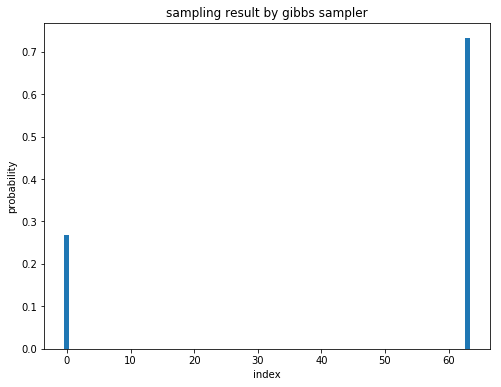

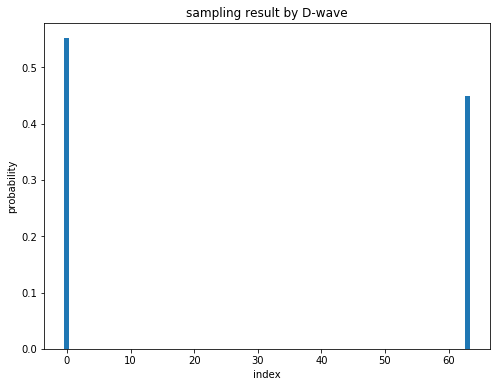

KL divergence by gibbs sampler : 0.11212002989486791
KL divergence by D-wave :  0.005650240927934647


In [308]:
disp_GT_per_index()
disp_result_per_index(data, np.ones(len(data)), 'gibbs sampler')
disp_result_per_index(decode_answer, num_answer, 'D-wave')
print 'KL divergence by gibbs sampler :', KL_divergence(data, np.ones(len(data)))
print 'KL divergence by D-wave : ', KL_divergence(decode_answer, num_answer)